# Simulation 

We will clone a repository with a test example for the NEBM and use the data files produced by the simulation:

In [1]:
!git clone https://github.com/fangohr/paper-2016-Cortes-etal-NEBM-test-system.git

Cloning into 'paper-2016-Cortes-etal-NEBM-test-system'...
remote: Counting objects: 103, done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 103 (delta 0), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (103/103), 4.33 MiB | 1.80 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [7]:
%%capture
!cd paper-2016-Cortes-etal-NEBM-test-system && make relaxation
!cd paper-2016-Cortes-etal-NEBM-test-system && make nebm

# NEBM Plot Functions

Once that the data is generated, we import the NEBM plot library:

In [1]:
import sys
sys.path.append('..')
import nebm_plot_functions as npf

import matplotlib.pyplot as plt

../nebm_plot_functions.py:14: UserWarning: The Energy scale is in Joules. If you want to use a different energy scale, you can redefine the neb_plot_functions.scale variable and, to change the labels, use the neb_plot_functions.scale_label variable. In this way, the energy data will be divided by *scale*, e.g. 
 import neb_plot_functions as npf 
npf.scale = 1000 
npf.scale_label = 'kJ' 
  warnings.warn(imp_message)


To get a nice style for the plots, we can use the `Lato` font. There are different functions defined in `npf` to replace the default matplotlib settings, we will use the one that can be used together with `%matplotlib inline`:

In [2]:
%matplotlib inline
npf.set_matplotlib_Lato()

## Data

In [3]:
base_folder = 'paper-2016-Cortes-etal-NEBM-test-system/'

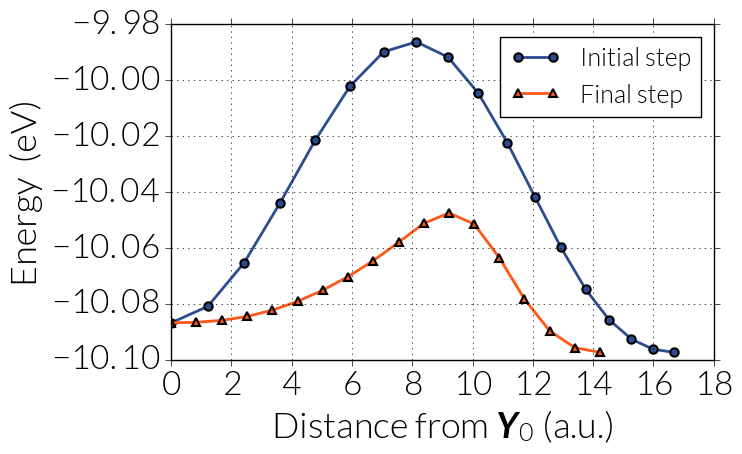

In [4]:
p = npf.plot_dist_vs_energy([
['neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt', 
 'neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Initial step', 0],
['neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt', 
 'neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Final step', -1],
],
legend_position='upper right',
# savef="energy.pdf"
scale=1.602e-19, scale_label='eV',
number_annotation=None,
rel_folder=base_folder
)

In [5]:
from fidimag.atomistic import Sim
from fidimag.common import CuboidMesh
from fidimag.atomistic import DMI
from fidimag.atomistic import UniformExchange
from fidimag.atomistic import Zeeman
# Import physical constants from fidimag
import fidimag.common.constant as const
from fidimag.common.nebm_geodesic import NEBM_Geodesic
# ------------------------------------------

mesh = CuboidMesh(nx=21, ny=21,
                  dx=0.5, dy=0.5,
                  unit_length=1e-9,
                  periodicity=(True, True, False)
                  )
sim = Sim(mesh, name='neb_21x21-spins_fm-sk_atomic')
sim.gamma = const.gamma
sim.mu_s = 2 * const.mu_B
sim.add(UniformExchange((10.0 / 1.) * const.meV))
sim.add(DMI((6 / 1.) * const.meV, dmi_type='interfacial'))
sim.add(Zeeman((0, 0, 25.)))


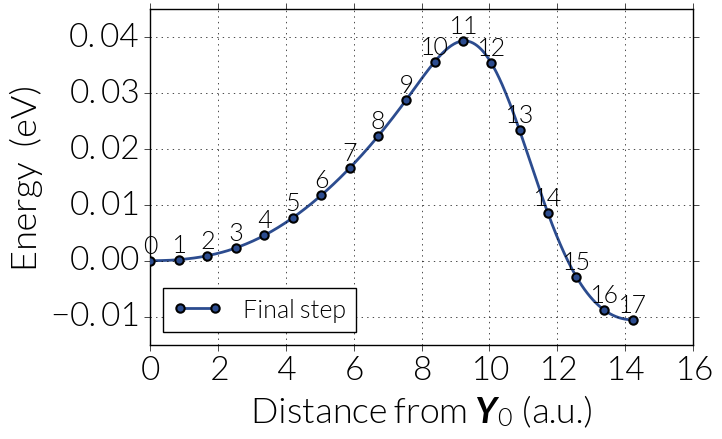

In [6]:
p = npf.plot_dist_vs_energy([
['neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt', 
 'neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 'Final step', -1,
 'npys/neb_21x21-spins_fm-sk_atomic_k1e4_97'
 ],
],
interpolate_energy=[NEBM_Geodesic, sim, 500],
legend_position='lower left',
# savef="energy.pdf"
scale=1.602e-19, scale_label='eV',
# number_annotation=0.5,
rel_folder=base_folder,
energy_shift=0,
ylim=[-0.015, 0.045]
)

In [57]:
import imp
imp.reload(npf)

<module 'nebm_plot_functions' from '../nebm_plot_functions.py'>

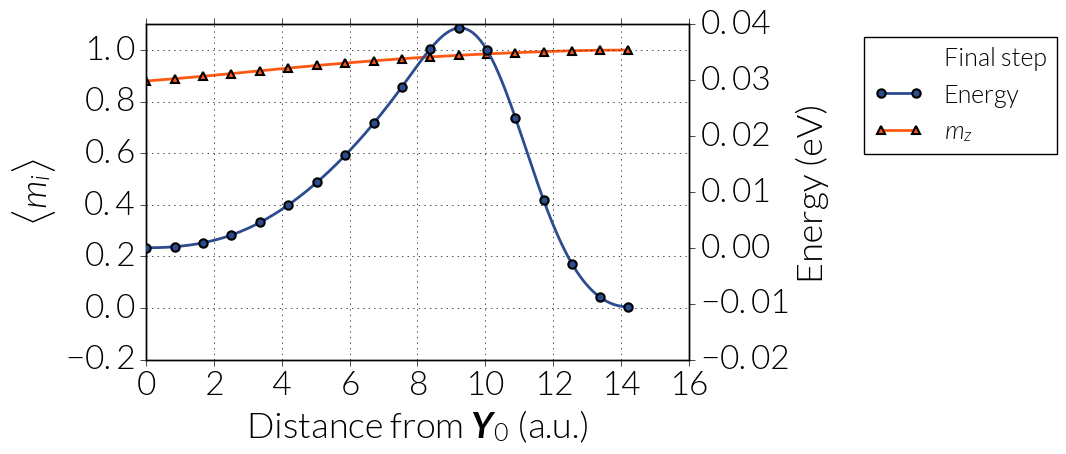

In [60]:
p = npf.plot_dist_vs_m(sim,
(False, False, True),
[
['neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Final step',
 97, 'neb_21x21-spins_fm-sk_atomic_k1e4',
 'neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt'
 ]],
number_annotation=[0.5, 0, 0],
legend_position=(1.3, 1.),
rel_folder=base_folder,
ylim=[-0.2, 1.1],
secondary_axis=[1.602e-19, 'eV'],
energy_shift=0,
interpolate_energy=[NEBM_Geodesic, 500],
backend='FIDIMAG'
)

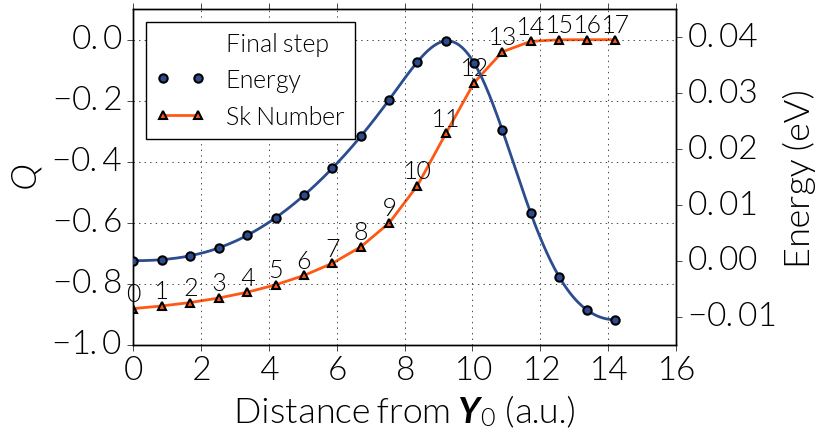

In [65]:
p = npf.plot_dist_vs_sknum(sim,
[
['neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Final step',
 97, 'neb_21x21-spins_fm-sk_atomic_k1e4',
 'neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt'
 ]],
number_annotation=[0.5, 0, 0],
legend_position='upper left',
rel_folder=base_folder,
ylim=[-1, 0.1],
ylim_en=[-0.015, 0.045],
secondary_axis=[1.602e-19, 'eV'],
energy_shift=0,
interpolate_energy=[NEBM_Geodesic, 500],
backend='FIDIMAG'
)